In [1]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap

import importlib
import utils.gmm
import utils.metrics
importlib.reload(utils.gmm)
importlib.reload(utils.metrics)
from utils.metrics import ClusteringMetrics
from utils.gmm import GaussianMixture

In [2]:
def plot_gmm(gmm, X, labels_pred, initial_means=None, initial_covariances=None, ax=None, title='Gaussian Mixture'):
    if ax is None:
        ax = plt.gca()
    
    cmap = ListedColormap(plt.cm.winter(np.linspace(0, 1, gmm.n_components)))    
    
    for i, color in zip(range(gmm.n_components), cmap.colors):
        mask = labels_pred == i
        ax.scatter(X[mask, 0], X[mask, 1], c=[color], s=1, zorder=1)

    # Plot ellipses and means
    for n, color in zip(range(gmm.n_components), cmap.colors):
        mean = gmm.means_[n].detach().cpu().numpy()
        
        # Determine covariance based on type
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n].detach().cpu().numpy()
        elif gmm.covariance_type == 'tied':
            cov = gmm.covariances_.detach().cpu().numpy()
        elif gmm.covariance_type == 'diagonal':
            cov = np.diag(gmm.covariances_[n].detach().cpu().numpy())
        elif gmm.covariance_type == 'spherical':
            cov = np.eye(gmm.n_features) * gmm.covariances_[n].detach().cpu().numpy()

        # Calculate ellipse parameters
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        # Plot ellipses for standard deviations
        for std_dev, alpha in zip([1, 2, 3], [0.6, 0.3, 0.1]):
            width, height = 2 * np.sqrt(vals) * std_dev
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor='black', facecolor=color, alpha=alpha, zorder=0)
            ax.add_patch(ellipse)

        # Plot mean as a dot
        ax.plot(mean[0], mean[1], 'ko', markersize=3, zorder=4)

    if initial_means is not None:
        for n in range(gmm.n_components):
            initial_mean = initial_means[n].detach().cpu().numpy()
            ax.plot(initial_mean[0], initial_mean[1], 'rx', markersize=10, zorder=4)
            if initial_covariances is not None:
                initial_cov = initial_covariances[n].detach().cpu().numpy()
                vals, vecs = np.linalg.eigh(initial_cov)
                order = vals.argsort()[::-1]
                vals, vecs = vals[order], vecs[:, order]
                theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

                width, height = 2 * np.sqrt(vals)
                ellipse = Ellipse(xy=initial_mean, width=width, height=height, angle=theta, edgecolor='red', linestyle='--', facecolor='none', zorder=4)
                ax.add_patch(ellipse)

    ax.set_title(title)
    ax.axis('equal')

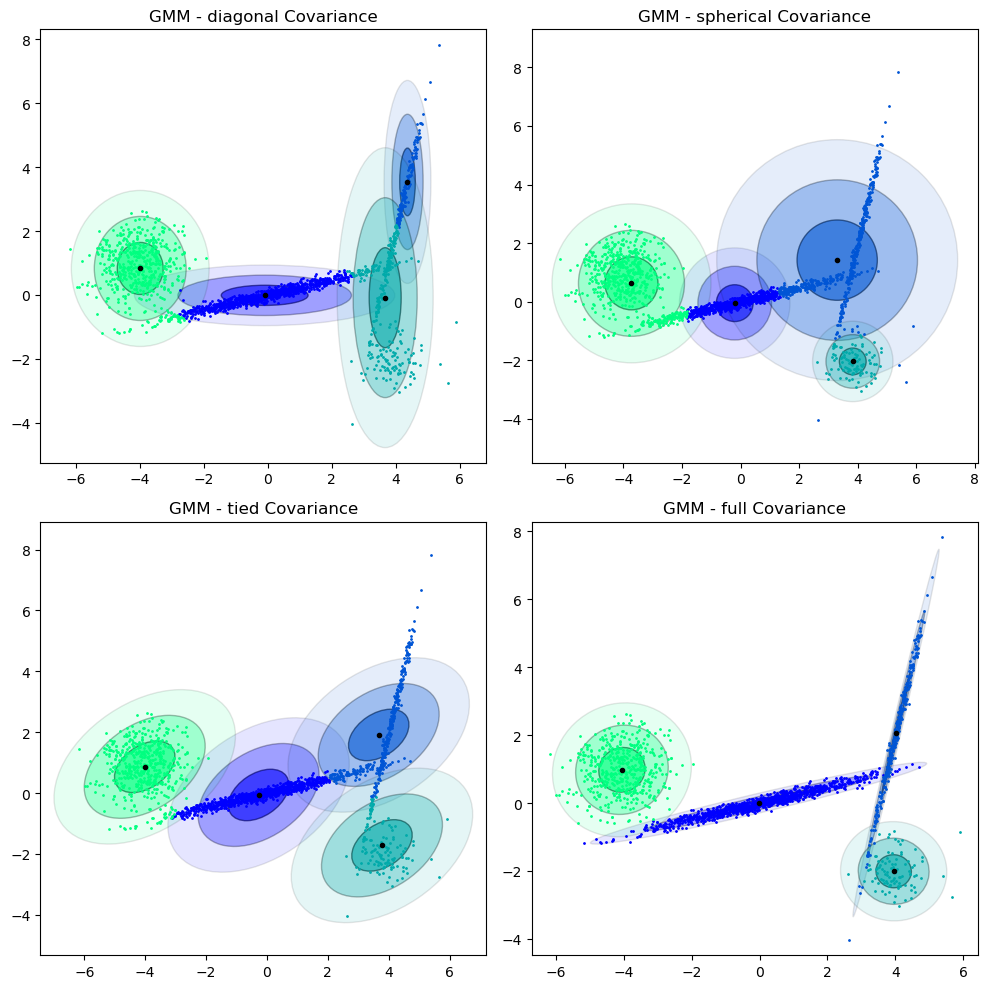

In [3]:
device = 'cpu'

init_params = 'random'
n_features = 2
n_components = 4
random_state = 42
n_init = 1
max_iter = 1000
np.random.seed(random_state)

n_samples_1 = 1000
n_samples_2 = 500
n_samples_3 = 100
n_samples_4 = 300
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
C_2 = np.array([[0.0, 0.2], [0.4, 1.7]])
component_1 = np.dot(np.random.randn(n_samples_1, 2), C)
component_2 = 0.7 * np.random.randn(n_samples_2, 2) + np.array([-4, 1])
component_3 = .5 * np.random.randn(n_samples_3, 2) + np.array([4, -2])
component_4 = np.dot(np.random.randn(n_samples_4, 2), C_2)+ np.array([4, 2])

X = np.concatenate([component_1, component_2, component_3, component_4])

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.cat([torch.zeros(n_samples_1), torch.ones(n_samples_2), 2 * torch.ones(n_samples_3), 3 * torch.ones(n_samples_4)]).long()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
covariance_types = ['diagonal', 'spherical', 'tied', 'full']

for ax, cov_type in zip(axs.ravel(), covariance_types):
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type=cov_type, max_iter=max_iter, n_init=n_init, init_params=init_params, random_state=random_state, device=device)
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X_tensor, y_pred, ax=ax, title=f'GMM - {cov_type} Covariance', initial_means=None, initial_covariances=None)

plt.tight_layout()
plt.show()

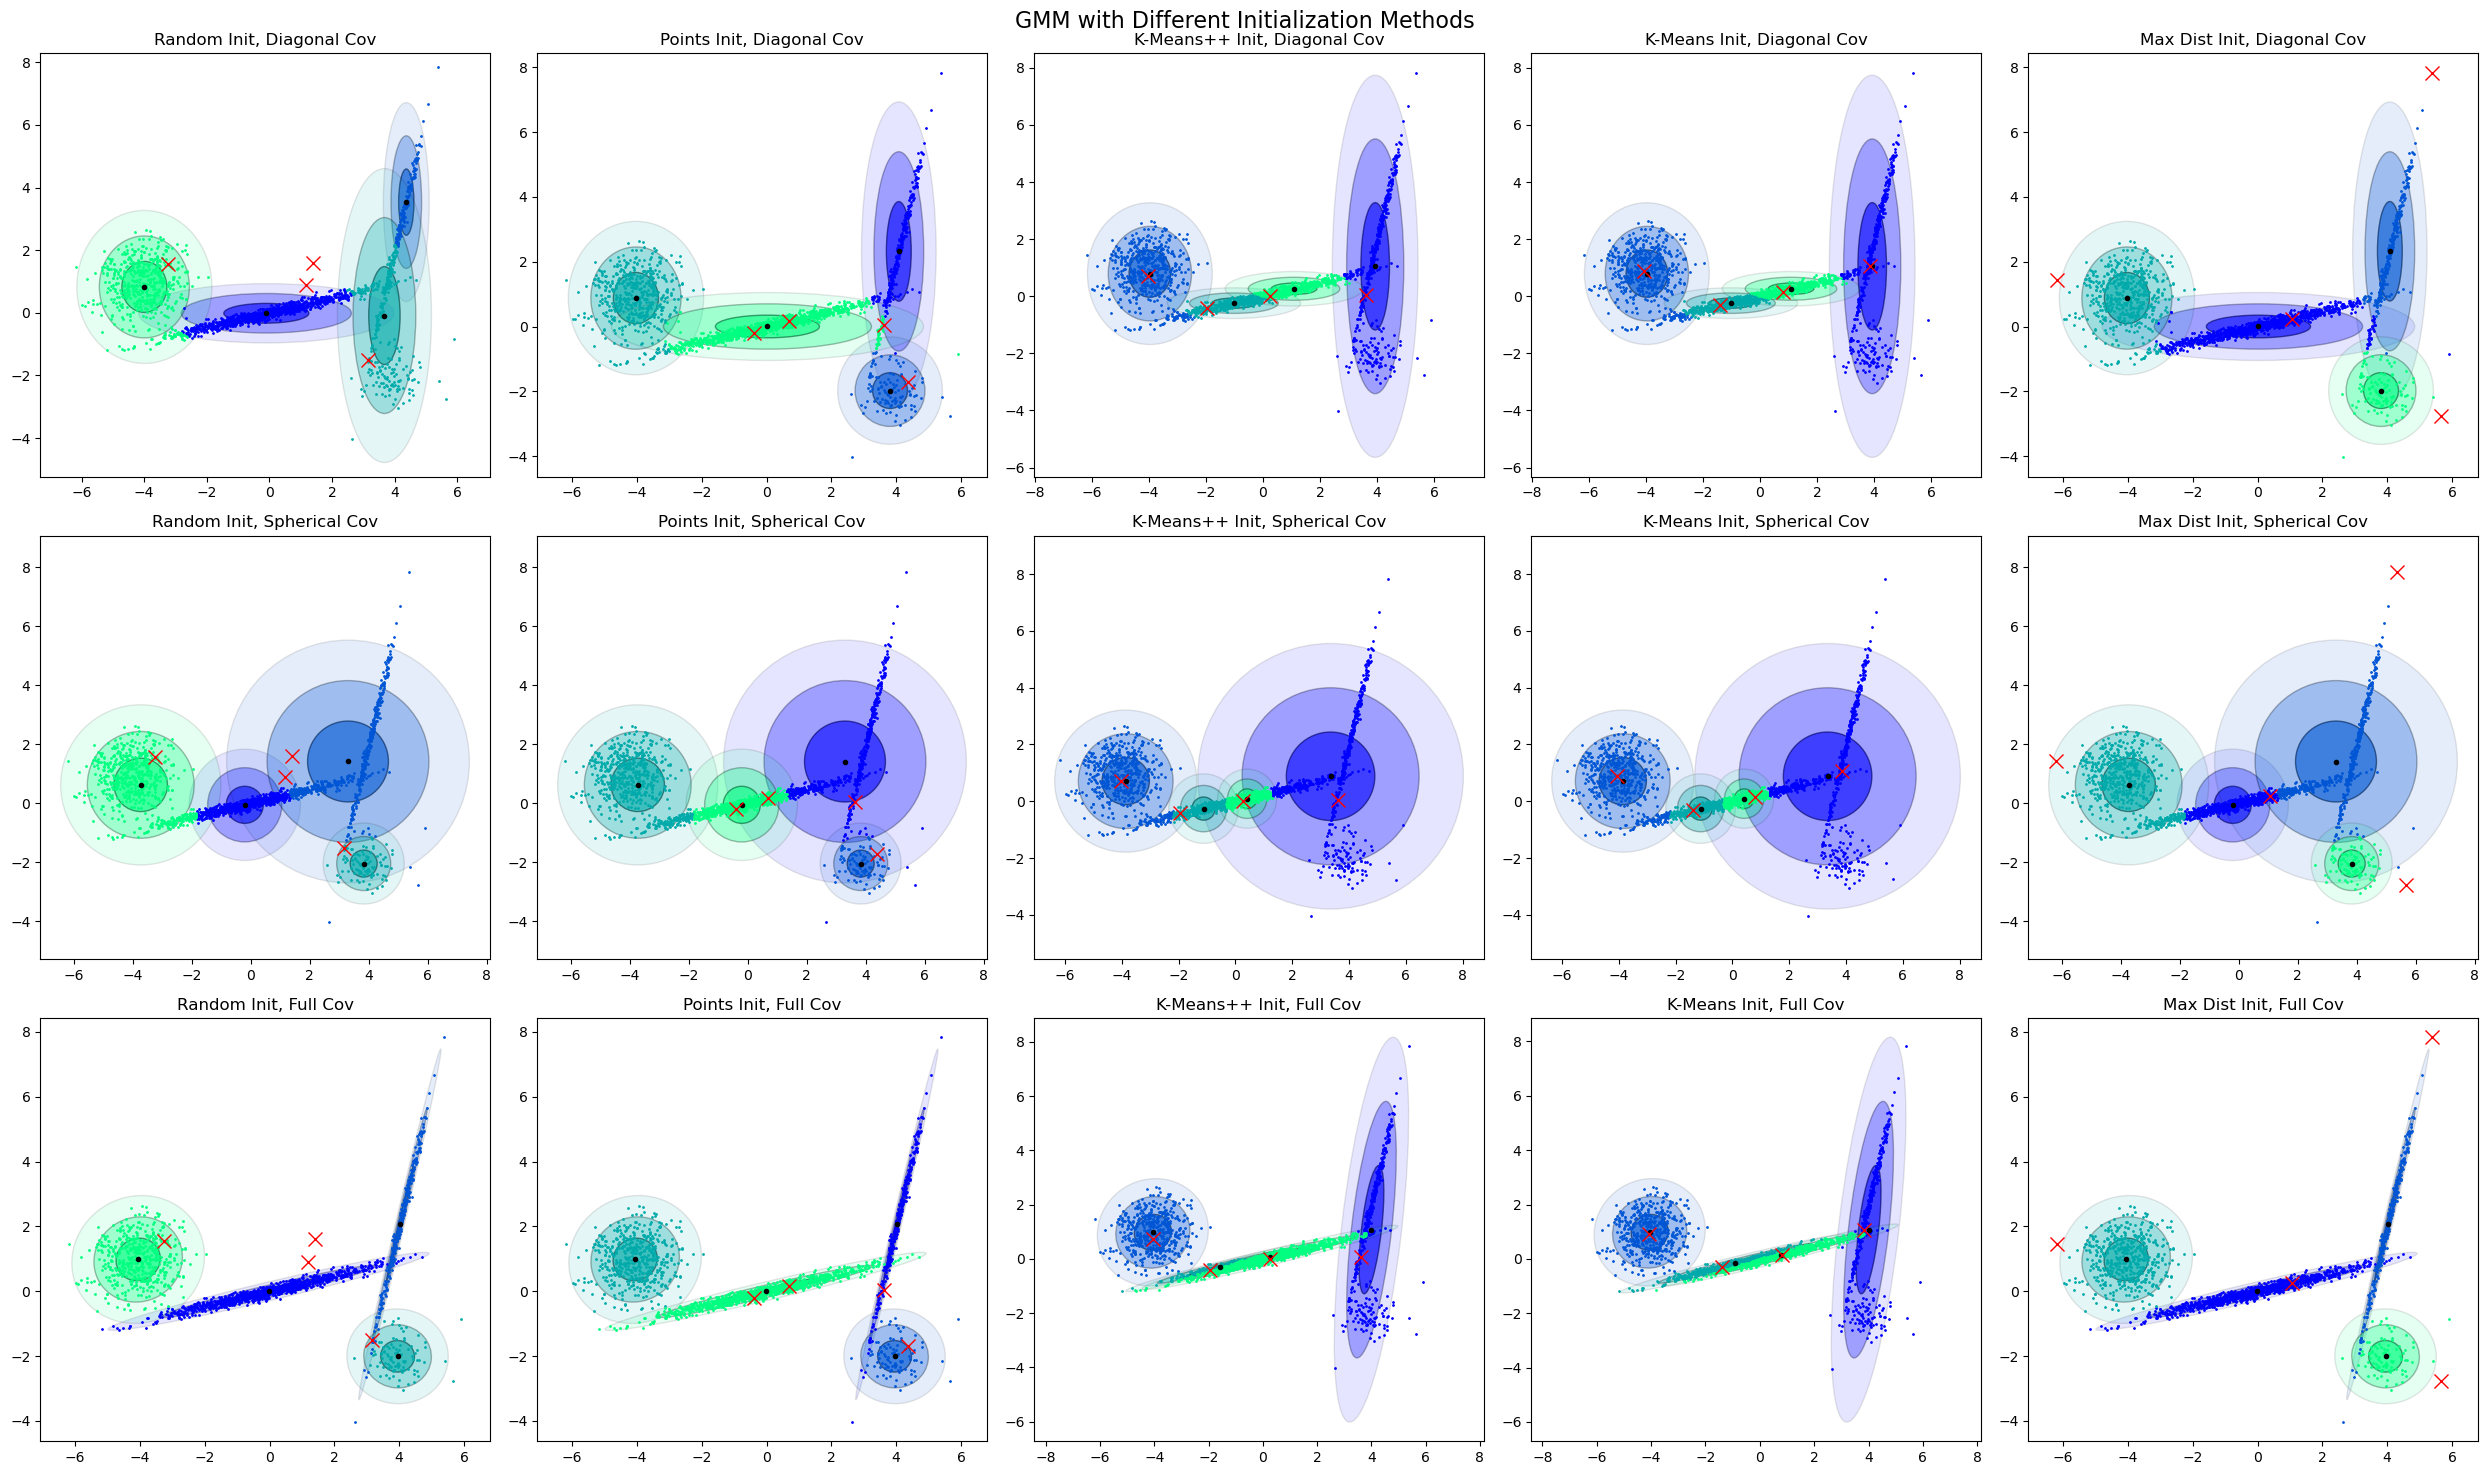

In [4]:
# Prepare the 3 by 5 plot for five initialization methods
fig, axs = plt.subplots(3, 5, figsize=(25, 15))
init_methods = ['random', 'points', 'kpp', 'kmeans', 'maxdist']
titles = ['Random Init', 'Points Init', 'K-Means++ Init', 'K-Means Init', 'Max Dist Init']

for ax, init_method, title in zip(axs[0,:], init_methods, titles):
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='diagonal', 
                          max_iter=max_iter, n_init=n_init, init_params=init_method, random_state=random_state, device=device)
    if init_method == 'points':
        gmm.means_init = gmm._init_kpoints(X_tensor, n_components)
    elif init_method == 'kpp':
        gmm.means_init = gmm._init_kpp(X_tensor, n_components)
    elif init_method == 'random':
        gmm.means_init = gmm._init_krandom(X_tensor, n_components)
    elif init_method == 'maxdist':
        gmm.means_init = gmm._init_maxdist(X_tensor, n_components)
    elif init_method == 'kmeans':
        gmm.means_init = gmm._init_kmeans(X_tensor, n_components)
    initial_mean = gmm.means_init
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, ax=ax, title=f'{title}, Diagonal Cov')

for ax, init_method, title in zip(axs[1,:], init_methods, titles):
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='spherical', 
                          max_iter=max_iter, n_init=n_init, init_params=init_method, random_state=random_state, device=device)
    if init_method == 'points':
        gmm.means_init = gmm._init_kpoints(X_tensor, n_components)
    elif init_method == 'kpp':
        gmm.means_init = gmm._init_kpp(X_tensor, n_components)
    elif init_method == 'random':
        gmm.means_init = gmm._init_krandom(X_tensor, n_components)
    elif init_method == 'maxdist':
        gmm.means_init = gmm._init_maxdist(X_tensor, n_components)
    elif init_method == 'kmeans':
        gmm.means_init = gmm._init_kmeans(X_tensor, n_components)
    initial_mean = gmm.means_init
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, initial_covariances=None, ax=ax, title=f'{title}, Spherical Cov')

for ax, init_method, title in zip(axs[2,:], init_methods, titles):
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='full', 
                          max_iter=max_iter, n_init=n_init, init_params=init_method, random_state=random_state, device=device)
    if init_method == 'points':
        gmm.means_init = gmm._init_kpoints(X_tensor, n_components)
    elif init_method == 'kpp':
        gmm.means_init = gmm._init_kpp(X_tensor, n_components)
    elif init_method == 'random':
        gmm.means_init = gmm._init_krandom(X_tensor, n_components)
    elif init_method == 'maxdist':
        gmm.means_init = gmm._init_maxdist(X_tensor, n_components)
    elif init_method == 'kmeans':
        gmm.means_init = gmm._init_kmeans(X_tensor, n_components)
    initial_mean = gmm.means_init
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, initial_covariances=None, ax=ax, title=f'{title}, Full Cov')

plt.suptitle('GMM with Different Initialization Methods', fontsize=16)
plt.tight_layout()
plt.show()

## Unsupervised clustering metrics

In [5]:
# Extend component range comparison to include Gap Statistic and Dunn Index
components_range = np.arange(2, 11)

silhouette = np.zeros(components_range.shape)
davies_bouldin = np.zeros(components_range.shape)
calinski_harabasz = np.zeros(components_range.shape)
gap_statistic = np.zeros(components_range.shape)
dunn_index = np.zeros(components_range.shape)
bic = np.zeros(components_range.shape)
aic = np.zeros(components_range.shape)

for i, n in tqdm(enumerate(components_range), total=len(components_range)):
    gmm = GaussianMixture(n_features=n_features, n_components=n, covariance_type='full',
                          max_iter=max_iter, n_init=n_init, init_params=init_params, random_state=random_state, device=device)
    gmm.fit(X_tensor)
    pred_labels = gmm.predict(X_tensor)
    silhouette[i] = ClusteringMetrics.silhouette_score(X_tensor, pred_labels, n_components=gmm.n_components)
    davies_bouldin[i] = ClusteringMetrics.davies_bouldin_index(X_tensor, pred_labels, n_components=gmm.n_components)
    calinski_harabasz[i] = ClusteringMetrics.calinski_harabasz_score(X_tensor, pred_labels, n_components=gmm.n_components)
    dunn_index[i] = ClusteringMetrics.dunn_index(X_tensor, pred_labels, n_components=gmm.n_components)
    bic[i] = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, gmm.n_components, gmm.covariance_type)
    aic[i] = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, gmm.n_components, gmm.covariance_type)


100%|██████████| 9/9 [00:18<00:00,  2.08s/it]


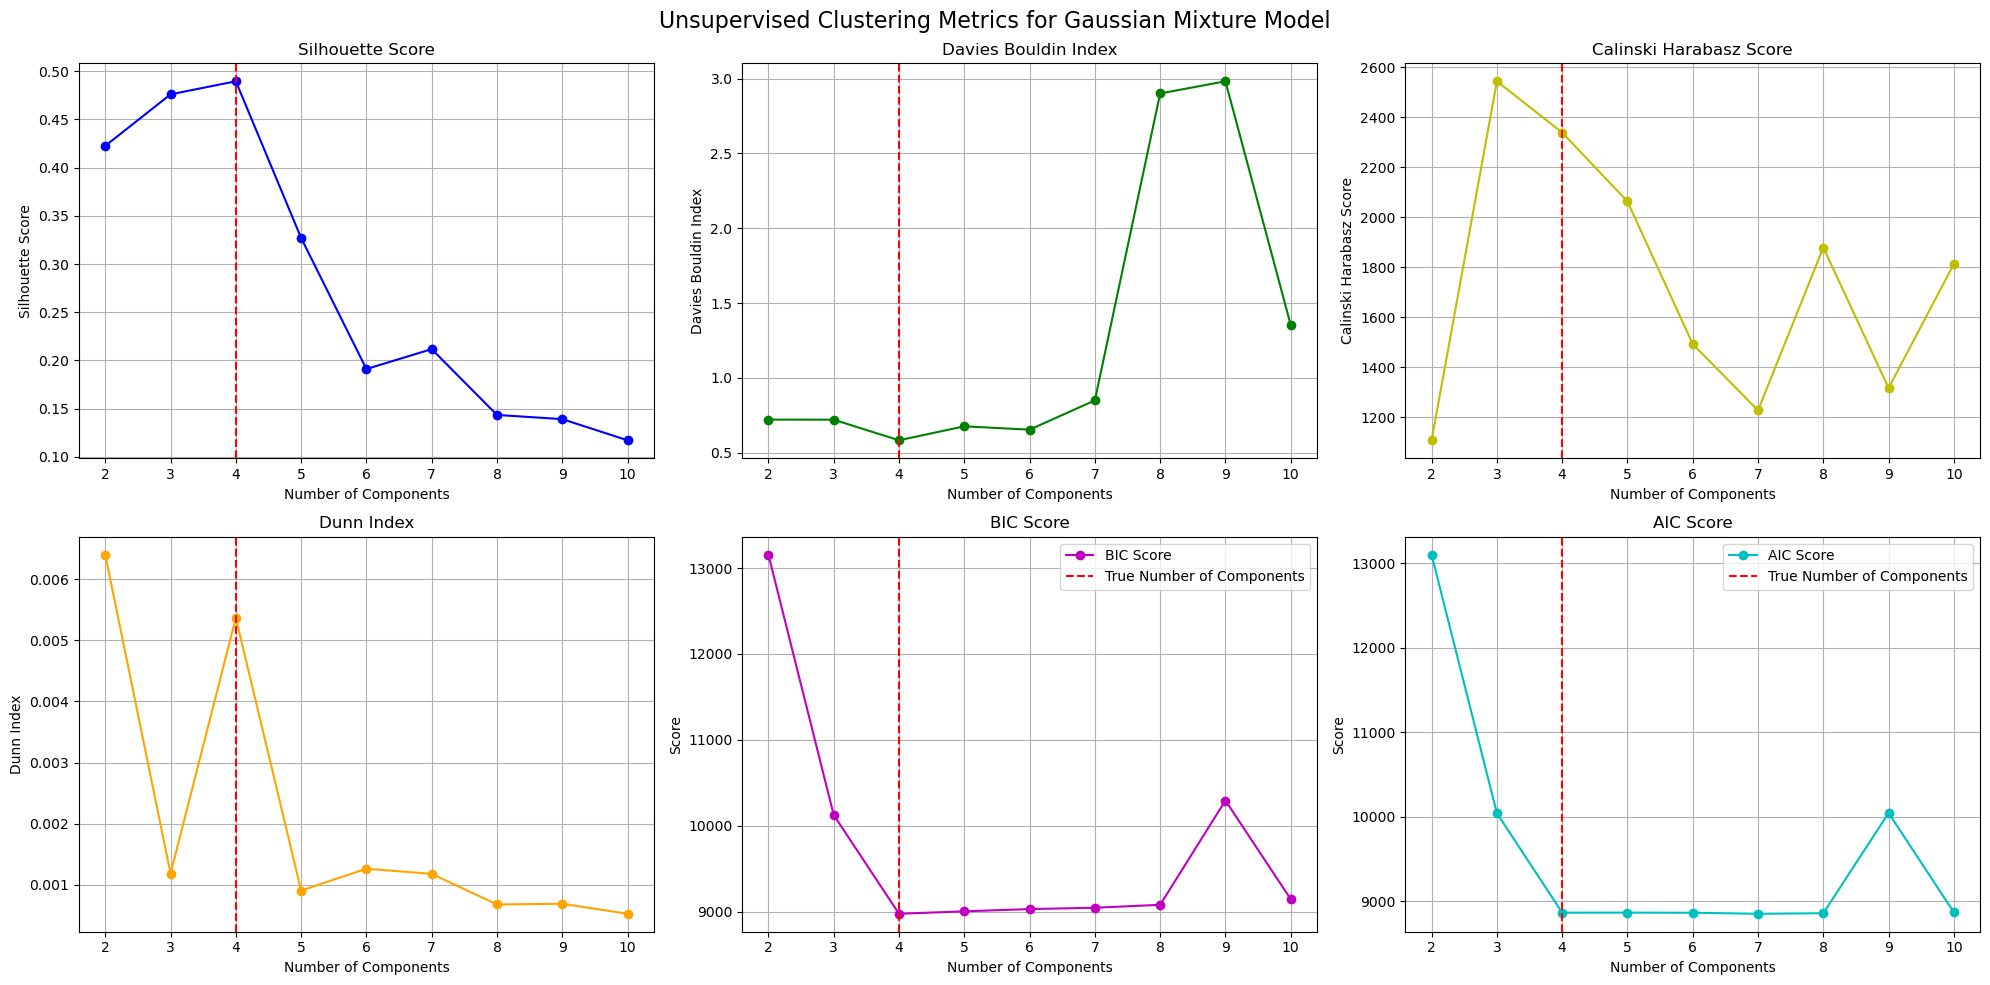

True number of components: 4
Ideal number of components based on Silhouette Score: 4
Ideal number of components based on Davies Bouldin Index: 4
Ideal number of components based on Calinski Harabasz Score: 3
Ideal number of components based on Dunn Index: 2
Ideal number of components based on BIC: 4
Ideal number of components based on AIC: 7


In [6]:
# Create 2 by 3 plot
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Silhouette Score
ax[0, 0].plot(components_range, silhouette, marker='o', color='b', label='Silhouette Score')
ax[0, 0].set_title('Silhouette Score')
ax[0, 0].set_xlabel('Number of Components')
ax[0, 0].set_ylabel('Silhouette Score')
ax[0, 0].grid(True)
ax[0, 0].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')

# Davies Bouldin Index
ax[0, 1].plot(components_range, davies_bouldin, marker='o', color='g', label='Davies Bouldin Index')
ax[0, 1].set_title('Davies Bouldin Index')
ax[0, 1].set_xlabel('Number of Components')
ax[0, 1].set_ylabel('Davies Bouldin Index')
ax[0, 1].grid(True)
ax[0, 1].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')

# Calinski Harabasz Score
ax[0, 2].plot(components_range, calinski_harabasz, marker='o', color='y', label='Calinski Harabasz Score')
ax[0, 2].set_title('Calinski Harabasz Score')
ax[0, 2].set_xlabel('Number of Components')
ax[0, 2].set_ylabel('Calinski Harabasz Score')
ax[0, 2].grid(True)
ax[0, 2].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')

# Dunn Index
ax[1, 0].plot(components_range, dunn_index, marker='o', color='orange', label='Dunn Index')
ax[1, 0].set_title('Dunn Index')
ax[1, 0].set_xlabel('Number of Components')
ax[1, 0].set_ylabel('Dunn Index')
ax[1, 0].grid(True)
ax[1, 0].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')

# BIC Score
ax[1, 1].plot(components_range, bic, marker='o', color='m', label='BIC Score')
ax[1, 1].set_title('BIC Score')
ax[1, 1].set_xlabel('Number of Components')
ax[1, 1].set_ylabel('Score')
ax[1, 1].grid(True)
ax[1, 1].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
ax[1, 1].legend()

# AIC Score
ax[1, 2].plot(components_range, aic, marker='o', color='c', label='AIC Score')
ax[1, 2].set_title('AIC Score')
ax[1, 2].set_xlabel('Number of Components')
ax[1, 2].set_ylabel('Score')
ax[1, 2].grid(True)
ax[1, 2].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
ax[1, 2].legend()


plt.suptitle('Unsupervised Clustering Metrics for Gaussian Mixture Model', fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()

# Print ideal number of components
print(f'True number of components: {n_components}')
print(f'Ideal number of components based on Silhouette Score: {components_range[np.argmax(silhouette)]}')
print(f'Ideal number of components based on Davies Bouldin Index: {components_range[np.argmin(davies_bouldin)]}')
print(f'Ideal number of components based on Calinski Harabasz Score: {components_range[np.argmax(calinski_harabasz)]}')
print(f'Ideal number of components based on Dunn Index: {components_range[np.argmax(dunn_index)]}')
print(f'Ideal number of components based on BIC: {components_range[np.argmin(bic)]}')
print(f'Ideal number of components based on AIC: {components_range[np.argmin(aic)]}')

## Supervised Clustering metrics

In [7]:
import torch
from matplotlib.patches import Ellipse
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd

def match_labels(y_true, y_pred):
    # Create the contingency table
    contingency_matrix = torch.zeros((y_true.max() + 1, y_pred.max() + 1), dtype=torch.int32)
    for i in range(y_true.size(0)):
        contingency_matrix[y_true[i], y_pred[i]] += 1
    
    # Apply the Hungarian algorithm to find the best match between true and predicted labels
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix.cpu().numpy())
    
    # Create a mapping from predicted to true labels
    label_mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    # Apply the mapping to y_pred
    matched_labels = torch.tensor([label_mapping[label.item()] for label in y_pred], dtype=torch.int64)
    return matched_labels

def plot_clustering(X, y_true, y_pred, means, covariances, ax, scores=None):
    y_pred = match_labels(y_true, y_pred)

    correct = y_true == y_pred
    incorrect = y_true != y_pred

    ax.scatter(X[correct][:, 0].cpu(), X[correct][:, 1].cpu(), c='lightblue', label='Correct prediction', s=5)
    ax.scatter(X[incorrect][:, 0].cpu(), X[incorrect][:, 1].cpu(), c='red', label='Incorrect prediction', s=5)

    for i in range(means.shape[0]):
        mean = means[i].cpu().numpy()
        cov = covariances[i].cpu().numpy()

        if i == 0:
            ax.scatter(mean[0], mean[1], c='black', marker='x', label=f'Mean')
        else:
            ax.scatter(mean[0], mean[1], c='black', marker='x')
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(5.991 * eigvals)
        if i == 0:
            ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--', label=f'95% CI')
        else:
            ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--')
        ax.add_patch(ell)

    ax.legend()
    ax.set_title('Clustering Results')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    # Display scores on the plot
    if scores is not None:
        score_text = '\n'.join([f"{metric}: {score:.2f}" for metric, score in scores.items()])
        ax.text(1.02, 0.5, score_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=1))

In [8]:
def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)

def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

def numpy_purity_score(labels_true, labels_pred):
    contingency = np.zeros((np.max(labels_true) + 1, np.max(labels_pred) + 1))
    for i in range(len(labels_true)):
        contingency[labels_true[i], labels_pred[i]] += 1
    return np.sum(np.max(contingency, axis=0)) / len(labels_true)

In [9]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_score, mutual_info_score, adjusted_mutual_info_score, completeness_score, v_measure_score, rand_score
from sklearn.mixture import GaussianMixture as SklearnGMM

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='full',
                      max_iter=max_iter, n_init=n_init, init_params=init_params, random_state=random_state, device=device)
gmm.fit(X_tensor)
y_pred = gmm.predict(X_tensor)

metrics = [
                # supervised clustering metrics
                "rand_score",
                "adjusted_rand_score",
                "mutual_info_score",
                "normalized_mutual_info_score",
                "adjusted_mutual_info_score",
                "fowlkes_mallows_score",
                "homogeneity_score",
                "completeness_score",
                "v_measure_score",
                "purity_score",
                # unsupervised clustering metrics
                "silhouette_score",
                "davies_bouldin_index",
                "calinski_harabasz_score",
                "dunn_index",
                "bic_score",
                "aic_score",
            ]

all_scores = gmm.evaluate_clustering(X_tensor, true_labels=y_tensor, metrics=metrics)

# Compare with sklearn metrics
sklearn_scores = {
    "rand_score": rand_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "adjusted_rand_score": adjusted_rand_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "mutual_info_score": mutual_info_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "normalized_mutual_info_score": normalized_mutual_info_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "adjusted_mutual_info_score": adjusted_mutual_info_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "fowlkes_mallows_score": fowlkes_mallows_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "homogeneity_score": homogeneity_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "completeness_score": completeness_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "v_measure_score": v_measure_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "silhouette_score": silhouette_score(X_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "davies_bouldin_index": davies_bouldin_score(X_tensor.cpu().numpy(), y_pred.cpu().numpy()),
    "calinski_harabasz_score": calinski_harabasz_score(X_tensor.cpu().numpy(), y_pred.cpu().numpy())
}

# Compare BIC and AIC scores
sklearn_gmm = SklearnGMM(n_components=n_components, covariance_type='full', max_iter=max_iter, n_init=n_init,
                         init_params=init_params, random_state=random_state)
sklearn_gmm.fit(X_tensor.cpu().numpy())
sklearn_bic = sklearn_gmm.bic(X_tensor.cpu().numpy())
torch_bic = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, n_components, gmm.covariance_type)
sklearn_aic = sklearn_gmm.aic(X_tensor.cpu().numpy())
torch_aic = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, n_components, gmm.covariance_type)
print(f"Torch BIC: {torch_bic}, Sklearn BIC: {sklearn_bic}, difference: {abs(torch_bic - sklearn_bic)}")
print(f"Torch AIC: {torch_aic}, Sklearn AIC: {sklearn_aic}, difference: {abs(torch_aic - sklearn_aic)}")

# Compare Dunn Index
cluster_centers = []
for i in range(n_components):
    cluster_centers.append(X_tensor[y_pred == i].mean(dim=0))
dunn_index_torch = dunn(cluster_centers)
torch_dunn = ClusteringMetrics.dunn_index(X_tensor, y_pred, n_components)
print(f"Torch Dunn Index: {torch_dunn:.5f}, Sklearn Dunn Index: {dunn_index_torch:.5f}, difference: {abs(torch_dunn - dunn_index_torch):.5f}")

torch_purity = ClusteringMetrics.purity_score(y_tensor, y_pred)
numpy_purity = numpy_purity_score(y_tensor.cpu().numpy(), y_pred.cpu().numpy())

print(f"Torch Purity: {torch_purity:.5f}, Numpy Purity: {numpy_purity:.5f}, difference: {abs(torch_purity - numpy_purity):.5f}")

# Add purity to your all_scores dictionary
all_scores['purity_score'] = torch_purity

# Update your comparison loop
print("\nComparison with sklearn metrics:\n")
for metric, value in all_scores.items():
    if metric in sklearn_scores:
        print(f"{metric}: sklearn: {sklearn_scores[metric]:.5f}, torch: {value:.5f}, difference: {abs(sklearn_scores[metric] - value):.5f}")



Torch BIC: 8976.634765625, Sklearn BIC: 8999.285284181571, difference: 22.650518556571114
Torch AIC: 8865.642578125, Sklearn AIC: 8871.644273383017, difference: 6.001695258017207
Torch Dunn Index: 0.00537, Sklearn Dunn Index: 0.00540, difference: 0.00003
Torch Purity: 0.99211, Numpy Purity: 0.99211, difference: 0.00000

Comparison with sklearn metrics:

rand_score: sklearn: 0.99161, torch: 0.99161, difference: 0.00000
adjusted_rand_score: sklearn: 0.98206, torch: 0.98206, difference: 0.00000
mutual_info_score: sklearn: 1.09647, torch: 1.09647, difference: 0.00000
adjusted_mutual_info_score: sklearn: 0.96458, torch: 0.96463, difference: 0.00005
normalized_mutual_info_score: sklearn: 0.96465, torch: 0.96465, difference: 0.00000
fowlkes_mallows_score: sklearn: 0.98874, torch: 0.98874, difference: 0.00000
homogeneity_score: sklearn: 0.96559, torch: 0.96565, difference: 0.00007
completeness_score: sklearn: 0.96372, torch: 0.96365, difference: 0.00007
v_measure_score: sklearn: 0.96465, torch

,Metric,Value
0,rand_score,0.991614
1,adjusted_rand_score,0.982058
2,mutual_info_score,1.096471
3,adjusted_mutual_info_score,0.964632
4,normalized_mutual_info_score,0.964653
5,fowlkes_mallows_score,0.988745
6,homogeneity_score,0.965651
7,completeness_score,0.963654
8,v_measure_score,0.964651
9,purity_score,0.992105


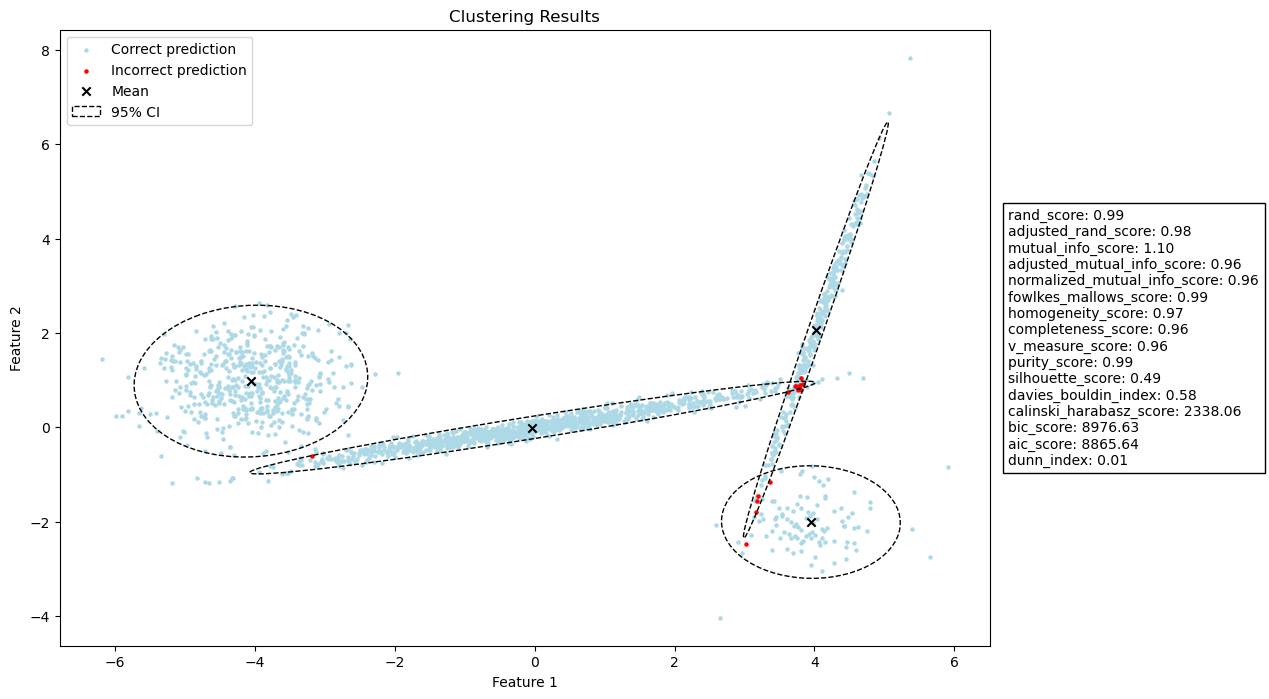

In [10]:
# Plot the clustering results
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_clustering(X_tensor, y_tensor, y_pred, gmm.means_, gmm.covariances_, ax, all_scores)

# print dataframe of all_scores
df = pd.DataFrame(all_scores.items(), columns=['Metric', 'Value'])
df


Confusion Matrix:
tensor([[991,   0,   0,   9],
        [  1, 499,   0,   0],
        [  0,   0,  95,   5],
        [  0,   0,   0, 300]], dtype=torch.int32)
Classification Report:
{0: {'precision': 0.998991935483871, 'recall': 0.991, 'f1-score': 0.9949799196787148, 'support': 1000, 'jaccard': 0.99000999000999, 'roc_auc': 0.9932888746261597}, 1: {'precision': 1.0, 'recall': 0.998, 'f1-score': 0.998998998998999, 'support': 500, 'jaccard': 0.998, 'roc_auc': 0.9999613761901855}, 2: {'precision': 1.0, 'recall': 0.95, 'f1-score': 0.9743589743589743, 'support': 100, 'jaccard': 0.95, 'roc_auc': 0.9775000810623169}, 3: {'precision': 0.9554140127388535, 'recall': 1.0, 'f1-score': 0.9771986970684039, 'support': 300, 'jaccard': 0.9554140127388535, 'roc_auc': 0.9949625134468079}}


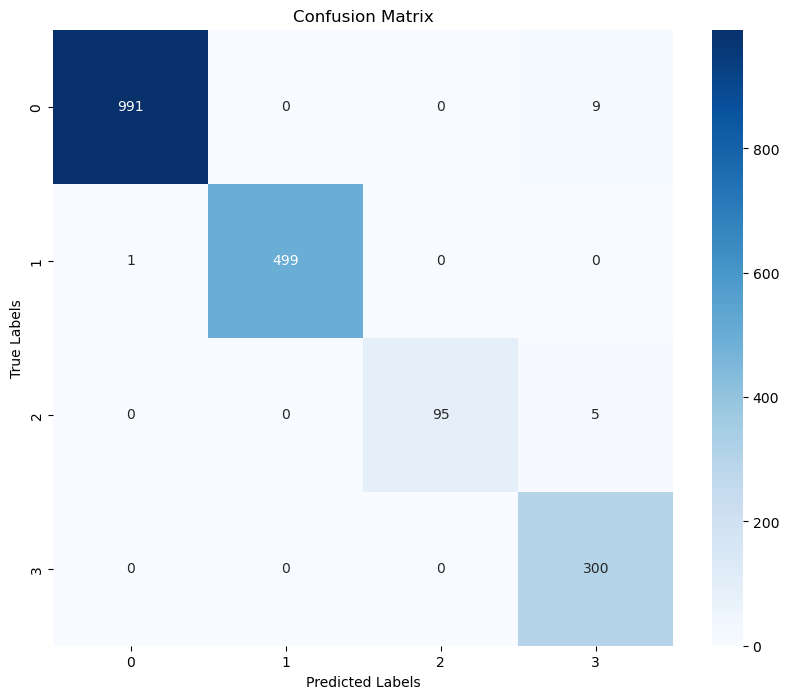

,precision,recall,f1-score,support,jaccard,roc_auc
0,0.998992,0.991,0.994980,1000.0,0.990010,0.993289
1,1.000000,0.998,0.998999,500.0,0.998000,0.999961
2,1.000000,0.950,0.974359,100.0,0.950000,0.977500
3,0.955414,1.000,0.977199,300.0,0.955414,0.994963


In [11]:
import seaborn as sns

y_pred = match_labels(y_tensor, y_pred)

# Get the confusion matrix
cm = ClusteringMetrics.confusion_matrix(y_tensor, y_pred)
print('Confusion Matrix:')
print(cm)

# Get the classification report
report = ClusteringMetrics.classification_report(y_tensor, y_pred)
print('Classification Report:')
print(report)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a DataFrame from the classification report
report_df = pd.DataFrame(report).transpose()
# Display the DataFrame
report_df

## Using Priors

In [14]:
from utils.priors import DirichletPrior, GaussianPrior, SoftballPrior, WishartPrior, InverseGammaPrior, LogNormalPrior

In [15]:
def plot_gmm(gmm, X, labels_pred, ax=None, title='Gaussian Mixture', color='green'):
    if ax is None:
        ax = plt.gca()
    
    ax.scatter(X[:, 0], X[:, 1], c='black', s=1, zorder=1)

    for n in range(gmm.n_components):
        mean = gmm.means_[n].detach().cpu().numpy()
        
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n].detach().cpu().numpy()
        elif gmm.covariance_type == 'tied':
            cov = gmm.covariances_.detach().cpu().numpy()
        elif gmm.covariance_type == 'diagonal':
            cov = np.diag(gmm.covariances_[n].detach().cpu().numpy())
        elif gmm.covariance_type == 'spherical':
            cov = np.eye(gmm.n_features) * gmm.covariances_[n].detach().cpu().numpy()
        
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        width, height = 2 * np.sqrt(vals) * 2
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=color, facecolor='none', lw=2, zorder=4)
        ax.add_patch(ellipse)

        ax.plot(mean[0], mean[1], 'o', color=color, markersize=5, zorder=5)

    ax.set_title(title)
    ax.axis('equal')

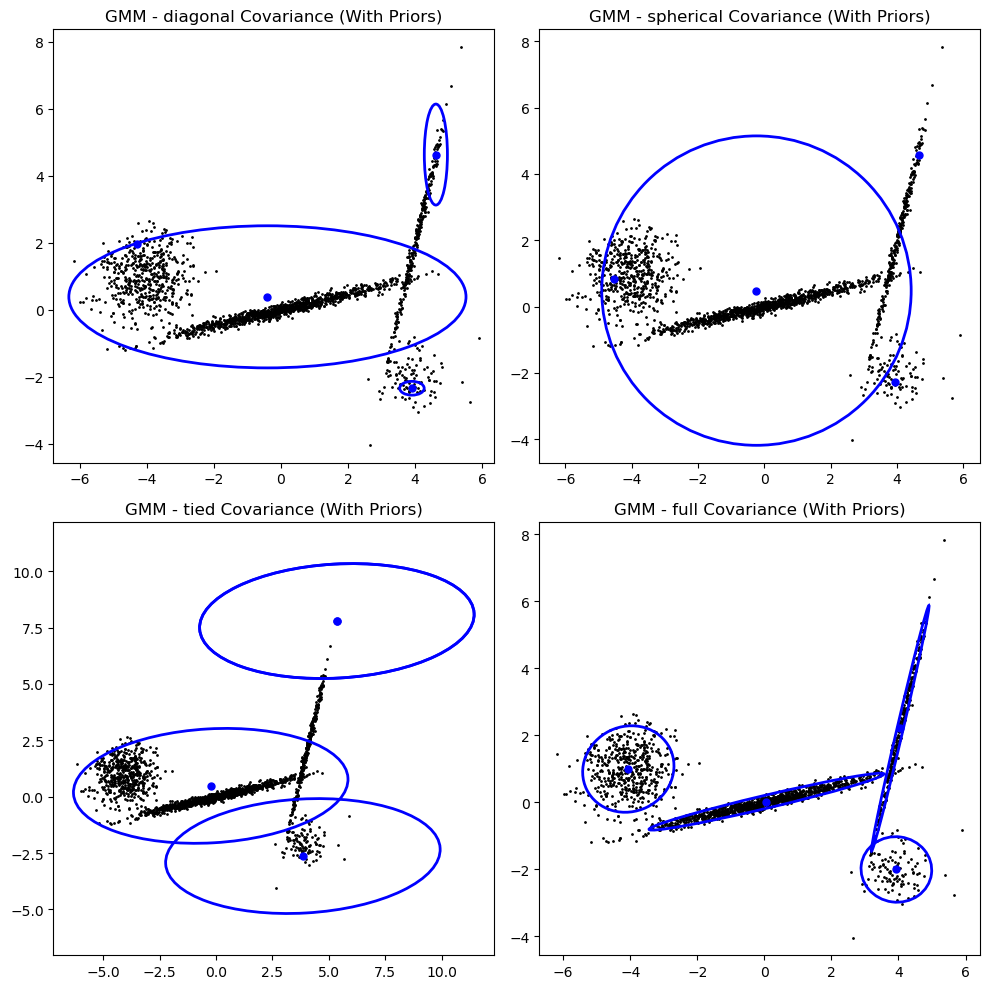

In [16]:
weights_prior_single = DirichletPrior(concentration=torch.tensor([1.0, 1.0, 1.0, 1.0]))
#mean_prior_single = GaussianPrior(dim=n_features, mean=torch.tensor([0.0, 0.0]), stddev=.1)
mean_prior_single = SoftballPrior(dim=n_features, radius=1.0)
#covariance_prior = InverseGammaPrior(alpha=1.0, beta=1.0)
covariance_prior = LogNormalPrior(mean=torch.tensor(0.0), stddev=torch.tensor(5.0))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, cov_type in zip(axs.ravel(), covariance_types):
    gmm = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type=cov_type,
        max_iter=max_iter,
        n_init=n_init,
        init_params=init_params,
        random_state=random_state,
        device=device,
        weights_prior=weights_prior_single,
        means_prior=mean_prior_single,
        covariances_prior=covariance_prior
    )
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X_tensor, y_pred, ax=ax, title=f'GMM - {cov_type} Covariance (With Priors)', color='blue')

plt.tight_layout()
plt.show()


### Using different Priors for each cluster element

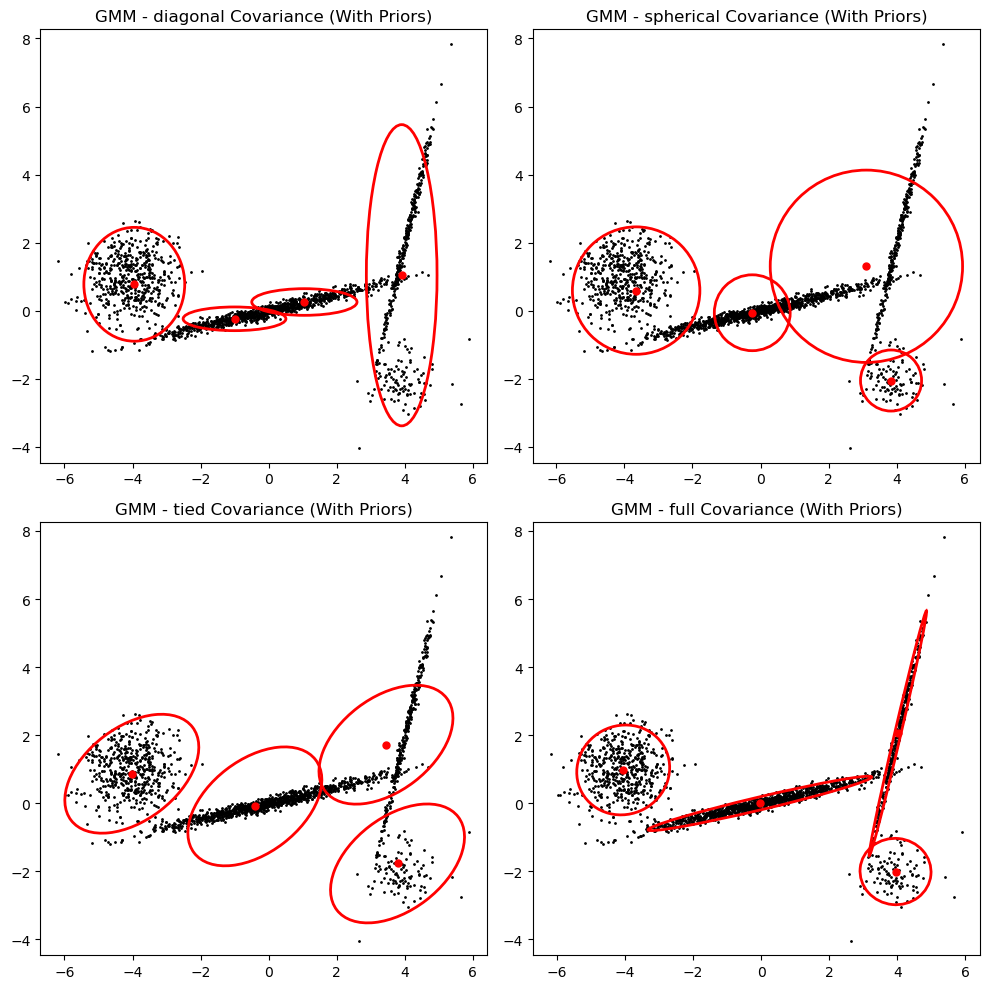

In [17]:

weights_prior = DirichletPrior(concentration=torch.tensor([1.0, 1.0, 1.0, 1.0]))
means_prior = [
    GaussianPrior(dim=n_features, mean=torch.tensor([-10.0, 10.0]), stddev=10),
    GaussianPrior(dim=n_features, mean=torch.tensor([10.0, 10.0]), stddev=10),
    GaussianPrior(dim=n_features, mean=torch.tensor([10.0, -10.0]), stddev=10),
    GaussianPrior(dim=n_features, mean=torch.tensor([-10.0, -10.0]), stddev=10),
]
precision_priors = {
    'spherical': WishartPrior(df=3, scale=torch.tensor(2.0), covariance_type='spherical'),
    'diagonal': WishartPrior(df=3, scale=torch.eye(n_features), covariance_type='diagonal'),
    'tied': WishartPrior(df=3, scale=torch.eye(n_features), covariance_type='tied'),
    'full': WishartPrior(df=3, scale=torch.eye(n_features), covariance_type='full')
}

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, cov_type in zip(axs.ravel(), covariance_types):
    gmm = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type=cov_type,
        max_iter=max_iter,
        n_init=n_init,
        init_params=init_params,
        random_state=random_state,
        device=device,
        weights_prior=weights_prior,
        means_prior=means_prior,
        precisions_prior=precision_priors[cov_type],
    )
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X_tensor, y_pred, ax=ax, title=f'GMM - {cov_type} Covariance (With Priors)', color='red')

plt.tight_layout()
plt.show()

